#  Import Necessary Libraries

In [2]:
import joblib
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [3]:
# filter Warnings
warnings.filterwarnings('ignore')

# Read the dataset

In [4]:
df = pd.read_csv('predictive_maintenance.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


# Data Analysis

In [5]:
print(df.info())
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
None


,count,mean,std,min,25%,50%,75%,max
UDI,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0
Air temperature [K],10000.0,300.00493,2.000259,295.3,298.30,300.1,301.50,304.5
Process temperature [K],10000.0,310.00556,1.483734,305.7,308.80,310.1,311.10,313.8
Rotational speed [rpm],10000.0,1538.77610,179.284096,1168.0,1423.00,1503.0,1612.00,2886.0
Torque [Nm],10000.0,39.98691,9.968934,3.8,33.20,40.1,46.80,76.6
Tool wear [min],10000.0,107.95100,63.654147,0.0,53.00,108.0,162.00,253.0
Target,10000.0,0.03390,0.180981,0.0,0.00,0.0,0.00,1.0


In [6]:
# Data Description of Object Data Types
df.describe(include= 'object')

,Product ID,Type,Failure Type
count,10000,10000,10000
unique,10000,3,6
top,M14860,L,No Failure
freq,1,6000,9652


In [7]:
# Check Null values in Data set and duplicates
print(df.isnull().sum())
print(df.duplicated().sum())

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64
0


In [8]:
# Droping UID , PRODUCT ID columns 
df.drop(df.columns[:2], axis=1, inplace= True)
df

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...
9995,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,H,299.0,308.7,1408,48.5,25,0,No Failure


In [9]:
# Filtering Categorical Calumns
cat_cols= df.select_dtypes(include= 'O').columns.tolist()
cat_cols

['Type', 'Failure Type']

In [10]:
# value counts for categorical columns
for col in cat_cols:
    print(df[col].value_counts())

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64
Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64


In [11]:
# Identify failure machines with 'Taregt' value 1

df_f = df[df.Target==1]
df_f['Failure Type'].value_counts()

Failure Type
Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
No Failure                    9
Name: count, dtype: int64

In [12]:
# Drop Rows that shows the Failure But Actually they are not

idx= df_f[df_f['Failure Type']== 'No Failure'].index
df.drop(idx, axis=0, inplace= True)


In [13]:
# Identify faulty machines with 'Taregt' value 0

df_f = df[df.Target==0]
df_f['Failure Type'].value_counts()

Failure Type
No Failure         9643
Random Failures      18
Name: count, dtype: int64

In [14]:
#Drop Not random Failure Which are not actually Failure 

idx= df_f[df_f['Failure Type']== 'Random Failures'].index
df.drop(idx, axis=0, inplace= True)


In [15]:
# Identify numerical Columns
num_cols= df.select_dtypes(exclude='O').columns.tolist()
num_cols

['Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]',
 'Target']

In [16]:
# Handling the Outliers in data
df.replace([np.inf, -np.inf], np.nan, inplace= True)

# Data Visualization

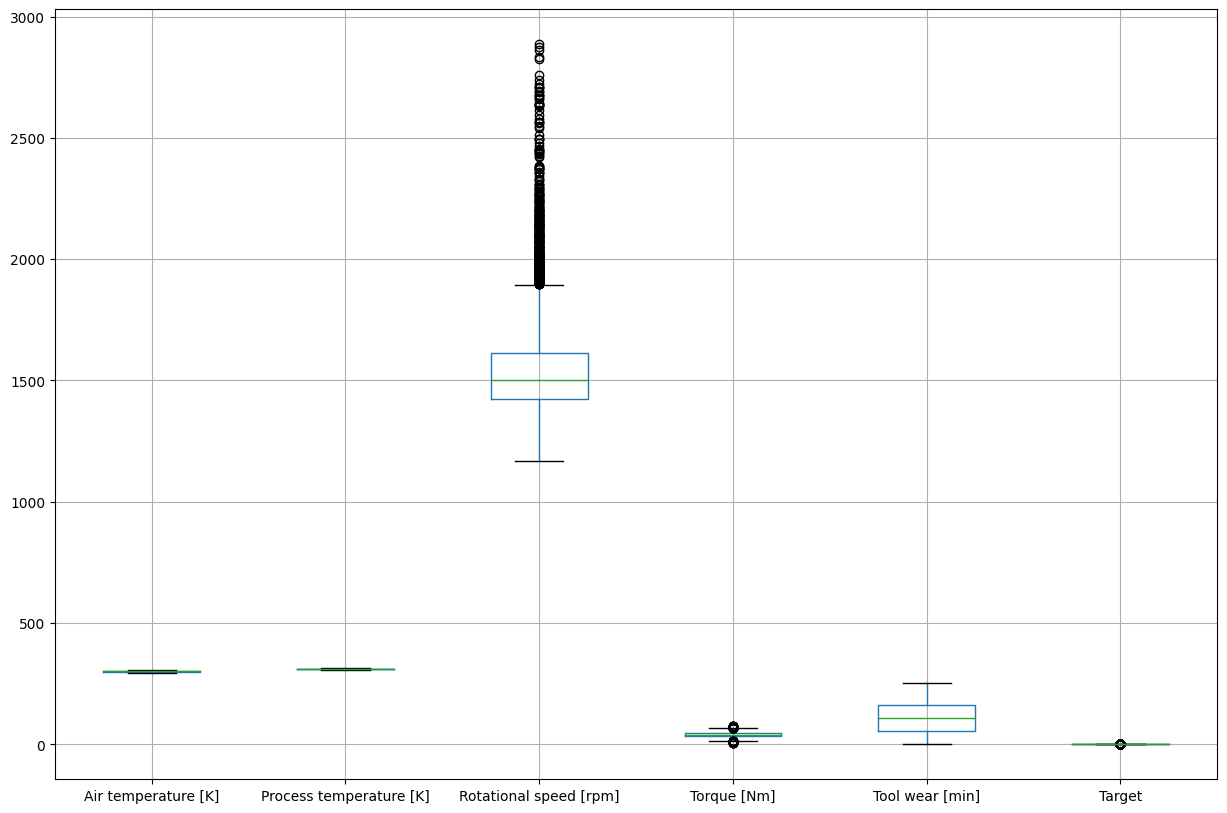

In [17]:
# Boxplot for all variables
df.boxplot(figsize= (15,10))
plt.show()

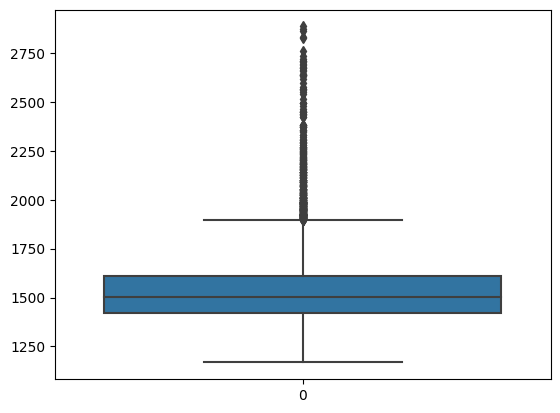

In [18]:
sns.boxplot(df['Rotational speed [rpm]'])
plt.show()

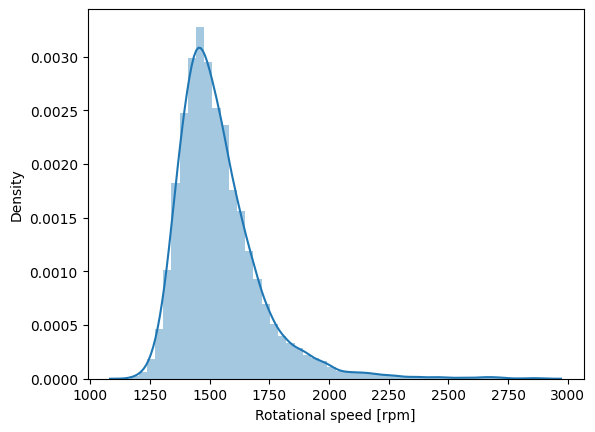

In [19]:
# Skewness of Rotational Speed
sns.distplot(df['Rotational speed [rpm]'])
plt.show()

This Distribution plot looks like Right Skewed

In [20]:
# Skewness value

from scipy.stats import skew

skewness = skew(df['Rotational speed [rpm]'])
print('Skewness: ', skewness)

Skewness:  1.9925593351071693


# Removing Outliers Using IQR Method

In [21]:
q1 = df['Rotational speed [rpm]'].quantile(0.25)
q3 = df['Rotational speed [rpm]'].quantile(0.75)

iqr = q3- q1

lower_limit = q1- 1.5 * iqr
upper_limit = q3 +1.5 * iqr

df = df[(df['Rotational speed [rpm]'] >= lower_limit) & 
        (df['Rotational speed [rpm]'] <= upper_limit)]

df.shape

(9555, 8)

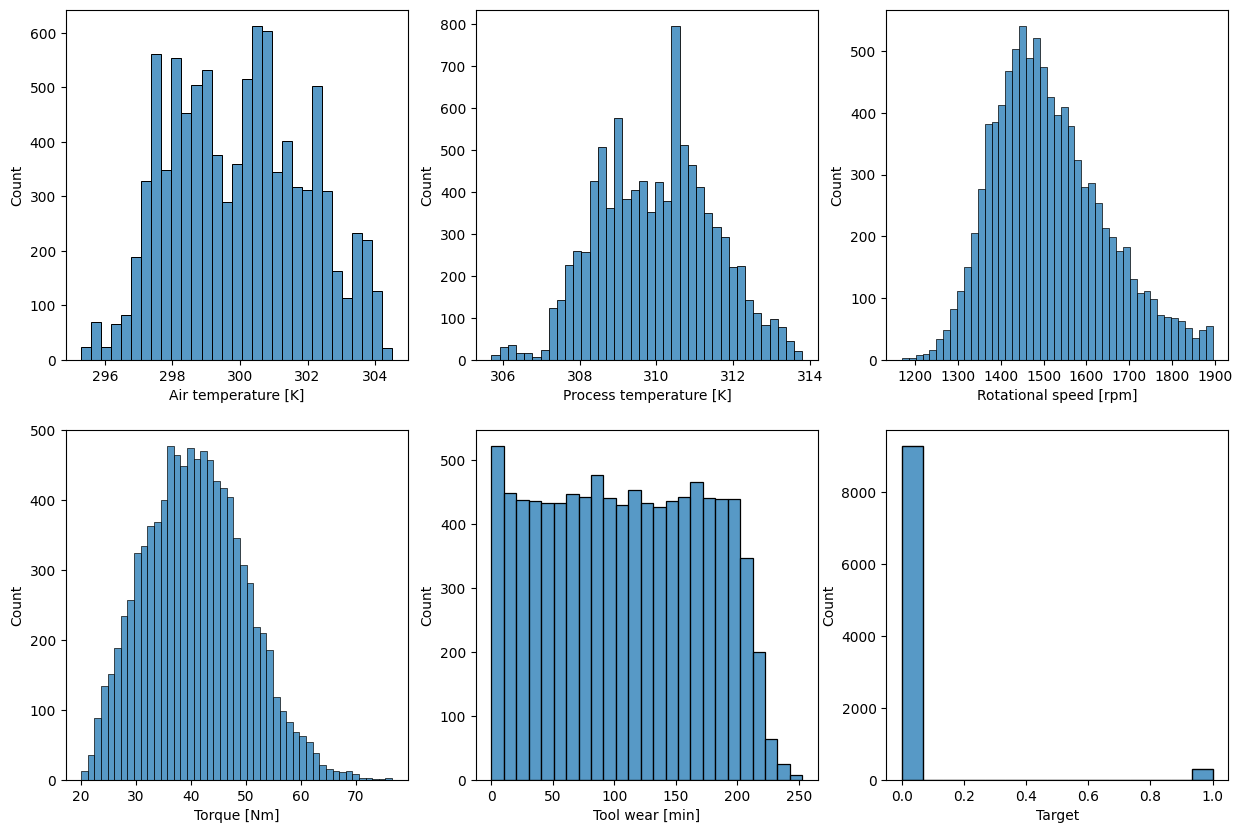

In [22]:

plt.figure(figsize= (15,10))
for i, col in  enumerate(num_cols, 1):
    plt.subplot(2,3,i)
    sns.histplot(data= df, x= col)
plt.show()

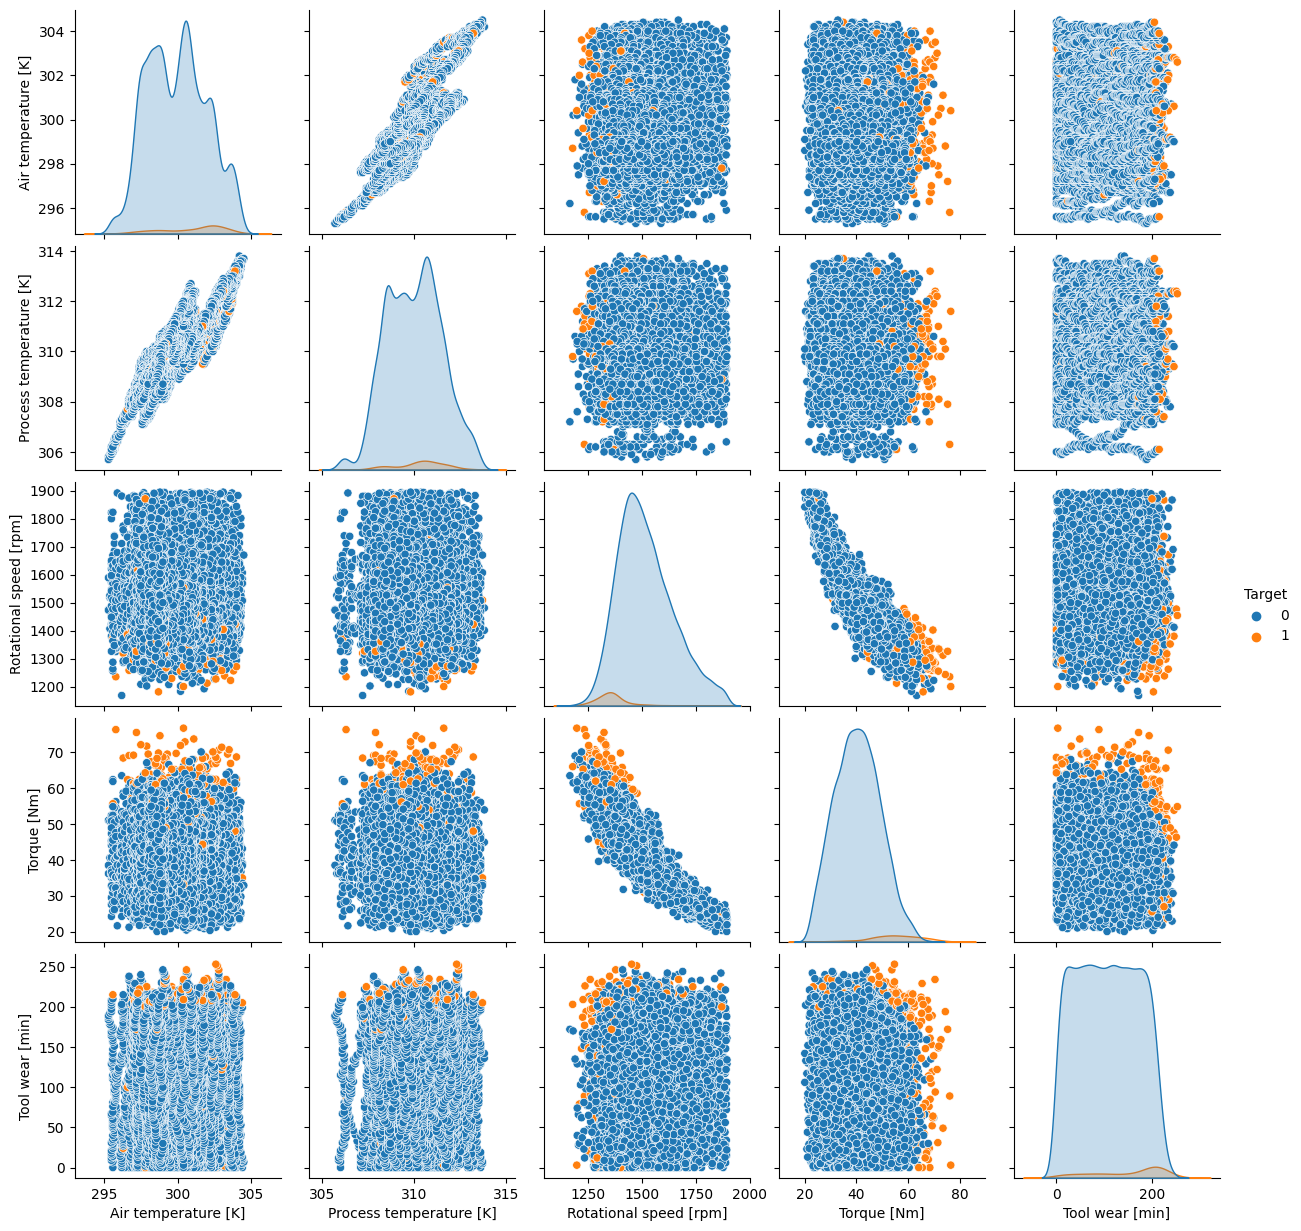

In [23]:
# pairplot
sns.pairplot(df, hue= 'Target')
plt.show()

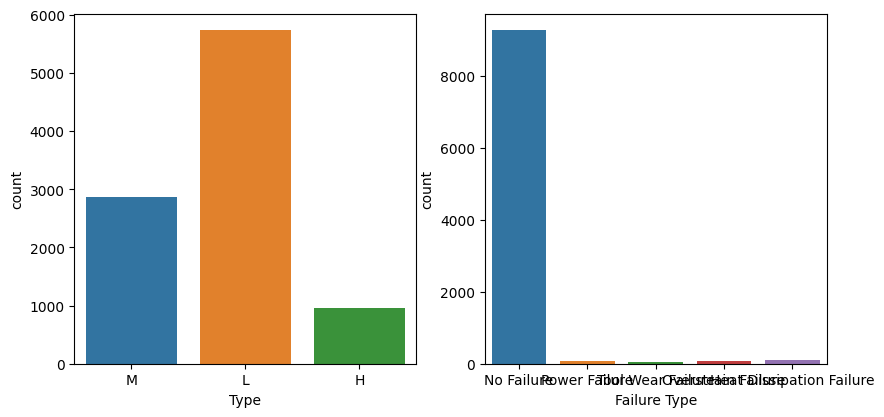

In [24]:
plt.figure(figsize= (15,10))

for i, col in  enumerate(cat_cols, 1):
    plt.subplot(2,3,i)
    sns.countplot(data= df, x= col)
plt.show()

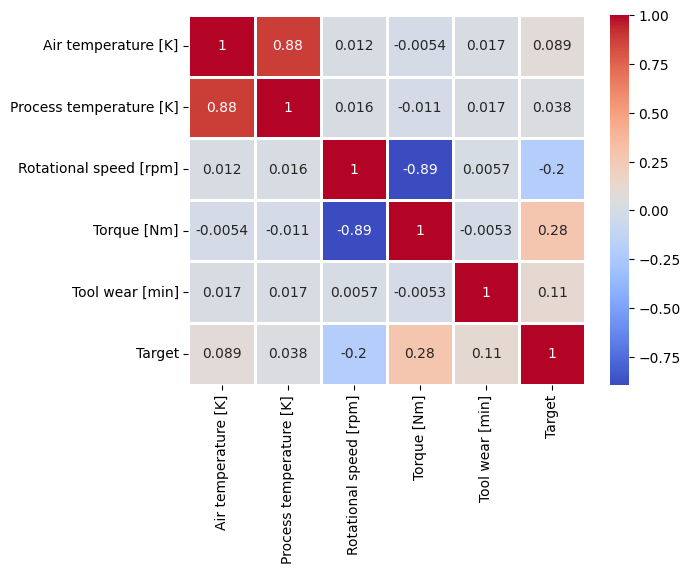

In [25]:
sns.heatmap(df.corr(numeric_only= True), annot= True, cmap= 'coolwarm', linewidths=2)
plt.show()

In [26]:
# get data description by target
df.groupby('Target').describe().T

Target                                   0            1
Air temperature [K]     count  9260.000000   295.000000
                        mean    299.961825   300.987458
                        std       1.987325     2.047600
                        min     295.300000   295.600000
                        25%     298.300000   299.200000
                        50%     300.000000   301.700000
                        75%     301.400000   302.600000
                        max     304.500000   304.400000
Process temperature [K] count  9260.000000   295.000000
                        mean    309.989266   310.318983
                        std       1.485227     1.333954
                        min     305.700000   306.100000
                        25%     308.800000   309.650000
                        50%     310.000000   310.500000
                        75%     311.000000   311.200000
                        max     313.800000   313.700000
Rotational speed [rpm]  count  9260.000000   295.000000
                        mean   1518.903996  1368.393220
                        std     128.887724    92.225219
                        min    1168.000000  1181.000000
                        25%    1426.000000  1321.500000
                        50%    1500.000000  1359.000000
                        75%    1597.250000  1383.500000
                        max    1895.000000  1871.000000
Torque [Nm]             count  9260.000000   295.000000
                        mean     40.452851    54.994915
                        std       8.699517    10.064246
                        min      20.100000    23.400000
                        25%      34.000000    48.700000
                        50%      40.300000    55.100000
                        75%      46.600000    62.300000
                        max      70.000000    76.600000
Tool wear [min]         count  9260.000000   295.000000
                        mean    106.698056   148.586441
                        std      62.856969    72.242353
                        min       0.000000     0.000000
                        25%      52.750000    89.500000
                        50%     106.000000   177.000000
                        75%     160.000000   208.000000
                        max     246.000000   253.000000

In [27]:
# drop 'Failure Type' and assign target to the y column

x= df.drop(['Target', 'Failure Type'], axis= 1)
y= df['Target']

In [28]:
# Splitting Data Into Train and test
X_train, X_test, y_train, y_test= train_test_split(x,y, test_size=0.2, random_state=42)

In [29]:
# Filtering the Categorical and Numerical Features for the Further Analysis and Operations
cat_cols= X_train.select_dtypes(include= "O").columns.tolist()
num_cols= X_train.select_dtypes(exclude= "O").columns.tolist()

print("category_cols",cat_cols)
print("num_cols",num_cols)

category_cols ['Type']
num_cols ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']


In [30]:
# Column Transformation For the Numerical and categorical features
enc= OneHotEncoder(handle_unknown= 'ignore')
sc= StandardScaler()

ct= ColumnTransformer(
        [
            ('encoding', enc, cat_cols),
            ('scaling', sc, num_cols)
        ]
)

In [31]:
X_train= ct.fit_transform(X_train)
X_test= ct.transform(X_test)

In [36]:
# Apply Smote for the data balance
X_resampled, y_resampled = SMOTE(sampling_strategy= 'minority', random_state= 42).fit_resample(X_train, y_train)

# Decision Tree After SMOTE

In [39]:
tree= DecisionTreeClassifier(max_depth=5) #increasing the depth increases the accuracy but causes overfitting
tree.fit(X_resampled, y_resampled)
y_pred = tree.predict(X_test)

In [40]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1861
           1       0.26      0.92      0.41        50

    accuracy                           0.93      1911
   macro avg       0.63      0.93      0.69      1911
weighted avg       0.98      0.93      0.95      1911

[[1732  129]
 [   4   46]]


In [41]:
decision_tree_smote= accuracy_score(y_test, y_pred)
print('Decision Tree After SMOTE:', decision_tree_smote)

Decision Tree After SMOTE: 0.9304029304029304


In [169]:
# Save the Model

model_data = {
    'model': tree,
    'column_transformer': ct
}
joblib.dump(model_data, './model.pkl')

['./models/model(all)(d=4).pkl']